# Goal
Create a notebook that segments cat faces using SegNet

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import theano
import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

from keras import models
from keras.optimizers import SGD

Using Theano backend.


# Load Data
Data comes from mom and I labeling, and google scraping using bin/scrape_google_images.py

![Cuter than a cat](https://s-media-cache-ak0.pinimg.com/originals/ea/7a/c1/ea7ac155ff8f9b19aa879ab656402b6a.jpg)

### Training: 
Pictures/train

### Testing:
Pictures/test

# Define Network

SegNet to start with: https://github.com/imlab-uiip/keras-segnet

In [32]:
path = 'Pictures/'
img_w = 256
img_h = 256
n_labels = 2

n_train = 384
n_test = 6

WITH_AUGMENTATION = 0
TRAIN_ENABLED = 1

In [3]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import json

img_w = 256
img_h = 256
n_labels = 2


if K.image_data_format() == 'channels_first':
    input_shape = (3, img_w, img_h)
else:
    input_shape = (img_w, img_h, 3)
    
kernel = 3

encoding_layers = [
    Conv2D(64, kernel, padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, kernel, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, 1, padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

In [4]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
__________

In [5]:
autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

with open('model_5l.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))
print('Compiled: OK')

Compiled: OK


In [6]:
from PIL import Image

def prep_data(path, mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    count = 0
    for i, item in df.iterrows():
        if i >= n:
            print("broken")
            break
        img, gt = [imread(item[0])], np.clip(imread(item[1]), 0, 1)
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
        count = count + 1
    sys.stdout.write('\r')
    sys.stdout.flush()
    
    data = np.array(data)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2], data.shape[3], data.shape[4]))
    print("There are counts: ", str(count))
    label = np.array(label).reshape((n, img_h * img_w, n_labels))
    print(label.shape)

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [7]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [8]:
train_data, train_label = prep_data('../Pictures/', 'train')

There are counts:  384=====>] 100%
(384, 65536, 2)
train: OK
	shapes: (384, 256, 256, 3), (384, 65536, 2)
	types:  uint8, float64
	memory: 72.0, 384.0 MB


In [33]:
test_data, test_label = prep_data('../Pictures/', 'test')

There are counts:  6======>] 100%
(6, 65536, 2)
test: OK
	shapes: (6, 256, 256, 3), (6, 65536, 2)
	types:  uint8, float64
	memory: 1.125, 6.0 MB


In [ ]:
datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely


In [11]:
from keras.callbacks import ModelCheckpoint

if WITH_AUGMENTATION:
  # augment the input images and their masks and save them into the tmp_training folder
  print("TODO")
else:
  nb_epoch = 50
  batch_size = 18
  autoencoder.compile(optimizer=SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = False),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
  print(train_data.shape)
  print(train_label.shape)

  checkpoint = ModelCheckpoint('.', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

(384, 256, 256, 3)
(384, 65536, 2)


In [13]:
if TRAIN_ENABLED:
  history = autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1,  callbacks=[checkpoint])

Epoch 1/50
384/384 [==============================] - 2822s - loss: 0.4978 - acc: 0.7581     

/usr/local/lib/python3.6/site-packages/keras/callbacks.py:390: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)



Epoch 2/50
384/384 [==============================] - 2799s - loss: 0.3970 - acc: 0.8061     

In [14]:
autoencoder.save_weights('model_5l_weight_ep50_384.hdf5')

In [15]:
autoencoder.load_weights('model_5l_weight_ep50_384.hdf5')

from keras.utils.vis_utils import plot_model

plot_model(autoencoder, to_file='model_384.png', show_shapes=True)

In [34]:
autoencoder.compile(optimizer=SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = False),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
score = autoencoder.evaluate(test_data, test_label, verbose=0)

print('Test score:',  score[0])
print('Test accuracy:', score[1])

Test score: 0.268084734678
Test accuracy: 0.899319946766


In [43]:
output = autoencoder.predict_proba(test_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

In [44]:
print(output.shape)

(6, 256, 256, 2)


In [ ]:
print(output)

In [53]:
def plot_results(output):
    gt = []
    df = pd.read_csv('../Pictures/test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(item[1]), 0, 1))

    plt.figure(figsize=(256, 2 * n_test))
    for i, item in df.iterrows():
        plt.subplot(n_test, 4, 4 * i + 1)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(item[1])
        plt.imshow(np.clip(gt, 0, 1))
        
        plt.subplot(n_test, 4, 4 * i + 2)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled)

        plt.subplot(n_test, 4, 4 * i + 3)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 4, 4 * i + 4)
        plt.title('Comparison')
        plt.axis('off')
        rgb = np.empty((img_h, img_w, 3))
        rgb[:, :, 0] = labeled
        img = imread(item[0])
        rgb[:, :, 1] = imread(item[1])
        rgb[:, :, 2] = gt
        plt.imshow(rgb)

    plt.savefig('result.png')
    plt.show()

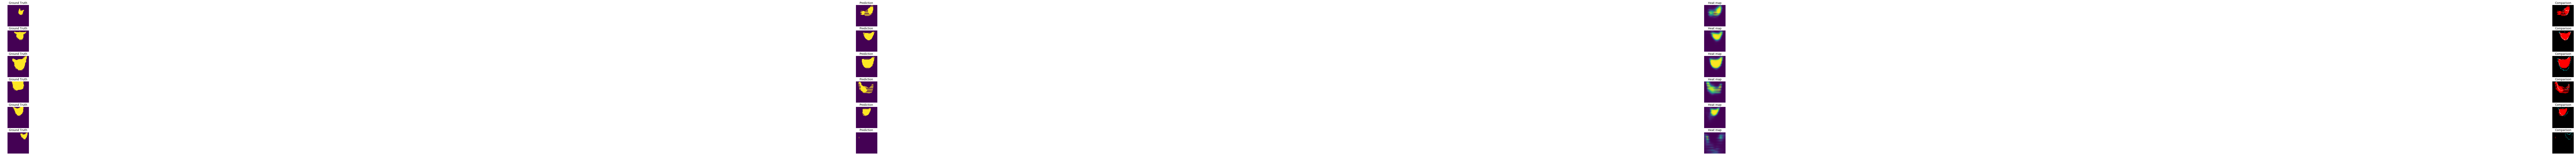

In [54]:
plot_results(output)